# Structure Function Turbulent Data

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os

import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F

import pytorch_lightning as pl
from pytorch_lightning.callbacks import Callback, ModelCheckpoint
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from torch.utils.data import Dataset, DataLoader

import matplotlib.pyplot as plt
from tqdm.notebook import tqdm as tqdm

# verify cuda
torch.cuda.is_available()
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")
# device = 'cpu'
print('Torch in running on', device)

Torch in running on cuda:0


In [3]:
from turboflow.utils import phy_utils as phy
from turboflow.utils import dsp_utils as dsp
from turboflow.utils import alg_utils as alg

from turboflow.callbacks import RefineSolution

## Input data

In [4]:
## SET UP DATA
path_to_data = '../data/2021-Turb2D_velocities.npy'
IMGs = np.load(path_to_data)

In [263]:
Re = 3000
delta_t = 0.01
n_images = 8
max_time = n_images*delta_t

X = IMGs[:n_images,:,:,:2] / 255
U = IMGs[:n_images,:,:,2:]

print(X.shape)

(8, 256, 256, 2)


In [264]:
original_time_size = X.shape[0]
original_img_size = X.shape[1]
print('Original size', original_img_size)
print('Original time', original_time_size)
t = np.arange(n_images) * delta_t

tmin, tmax = np.min(t), np.max(t)
xmin, xmax = np.min(X[0,:,:,0]), np.max(X[0,:,:,0])
ymin, ymax = np.min(X[0,:,:,1]), np.max(X[0,:,:,1])

print('tmin', tmin, 'tmax', tmax)
print('xmin', xmin, 'xmax', xmax)
print('ymin', ymin, 'ymax', ymax)

# normalize output
y = U.copy()
print('Y shape', y.shape)
print('Y min, max:', np.min(y), np.max(y))
y = y / np.max(np.abs(y))
print('after normalization, Y min, max:', np.min(y), np.max(y))

Original size 256
Original time 8
tmin 0.0 tmax 0.07
xmin 0.0 xmax 1.0
ymin 0.0 ymax 1.0
Y shape (8, 256, 256, 2)
Y min, max: -3.497054 2.374197
after normalization, Y min, max: -1.0 0.6789134511505971


Warning *** CHECK THE GRADIENT DIRECTION
Warning *** CHECK THE GRADIENT DIRECTION


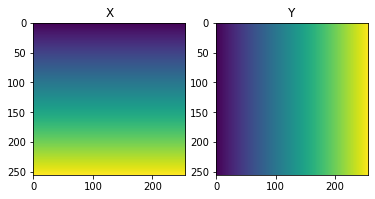

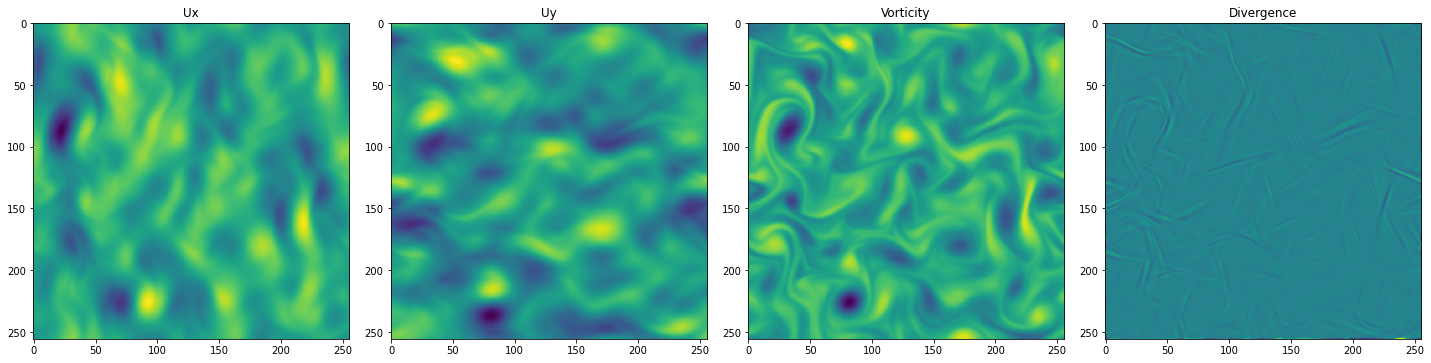

In [265]:
i = np.random.randint(n_images)

W = phy.compute_vorticity(U[i,:,:,0],U[i,:,:,1])
D = phy.compute_divergence(U[i,:,:,0],U[i,:,:,1])

plt.figure()
plt.subplot(121)
plt.imshow(X[i,:,:,0])
plt.title('X')
plt.subplot(122)
plt.imshow(X[i,:,:,1])
plt.title('Y')
plt.show()

plt.figure(figsize=(20,20))
plt.subplot(141)
plt.imshow(U[i,:,:,0])
plt.title('Ux')
plt.subplot(142)
plt.imshow(U[i,:,:,1])
plt.title('Uy')
plt.subplot(143)
plt.imshow(W)
plt.title('Vorticity')
plt.subplot(144)
plt.imshow(D)
plt.title('Divergence')
plt.tight_layout()
plt.show()

Check periodicity


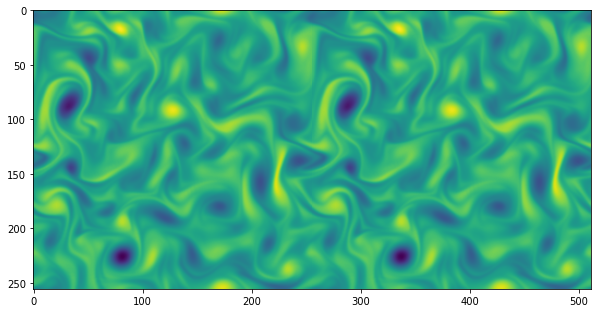

In [266]:
print('Check periodicity')
plt.figure(figsize=(10,10))
plt.imshow(np.concatenate([W, W], axis=1))
plt.show()

In [267]:
# original grid
coords_t_gt = np.linspace(tmin, tmax, original_time_size)
coords_x_gt = np.linspace(xmin, xmax, original_img_size)
coords_y_gt = np.linspace(ymin, ymax, original_img_size)

meshgrid_gt = alg.make_xyt_grid(coords_t_gt, 
                                coords_x_gt, 
                                coords_y_gt)
print(meshgrid_gt.shape)

(8, 256, 256, 3)


In [268]:
# downsampled resolution
scale_img = 1/4
scale_time = 1/2
coords_t_ds = coords_t_gt[::2]
# coords_x_ds = np.linspace(xmin, xmax, int(original_img_size * scale_img))
# coords_y_ds = np.linspace(ymin, ymax, int(original_img_size * scale_img))
coords_x_ds = coords_x_gt[::4]
coords_y_ds = coords_y_gt[::4]

meshgrid_ds = alg.make_xyt_grid(coords_t_ds, 
                                coords_x_ds, 
                                coords_y_ds)
print(meshgrid_ds.shape)

(4, 64, 64, 3)


In [269]:
# interpolate images
print(coords_t_gt[:5])
print(coords_x_gt[:5])
print(coords_y_gt[:5])

print(coords_t_ds[:5])
print(coords_x_ds[:5])
print(coords_y_ds[:5])

ux_ds = dsp.interpolate2D_t(coords_t_gt, coords_x_gt, coords_y_gt, y[:,:,:,0],
                            coords_t_ds, coords_x_ds, coords_y_ds)
uy_ds = dsp.interpolate2D_t(coords_t_gt, coords_x_gt, coords_y_gt, y[:,:,:,1],
                             coords_t_ds, coords_x_ds, coords_y_ds)
u_ds = np.stack([ux_ds,uy_ds], axis=-1)

res_out_ds = u_ds.shape

[0.   0.01 0.02 0.03 0.04]
[0.         0.00392157 0.00784314 0.01176471 0.01568627]
[0.         0.00392157 0.00784314 0.01176471 0.01568627]
[0.   0.02 0.04 0.06]
[0.         0.01568627 0.03137255 0.04705882 0.0627451 ]
[0.         0.01568627 0.03137255 0.04705882 0.0627451 ]


(8, 256, 256, 3)
(1, 64, 64, 3)


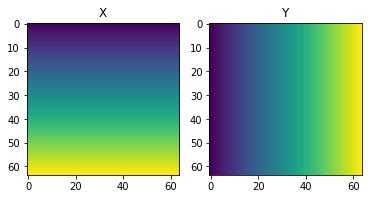

(1, 64, 64, 3)


In [270]:
meshgrid_gt = alg.make_xyt_grid(coords_t_gt, coords_x_gt, coords_y_gt)
print(meshgrid_gt.shape)

meshgrid_ds4 = alg.make_xyt_grid(coords_t_ds4, coords_x_ds4, coords_y_ds4)
print(meshgrid_ds4.shape)

plt.subplot(121)
plt.imshow(meshgrid_ds4[0,:,:,1])
plt.title('X')
plt.subplot(122)
plt.imshow(meshgrid_ds4[0,:,:,2])
plt.title('Y')
plt.show()

res_in_ds4 = meshgrid_ds4.shape
print(res_in_ds4)

In [271]:
n_dim_in = 3
n_dim_out = 2


coords_gt = meshgrid_gt.reshape(-1,n_dim_in)
u_gt = y.reshape(-1,n_dim_out)
print('HR:', coords_gt.shape, '->', u_gt.shape)

coords_ds = meshgrid_ds.reshape(-1,n_dim_in)
u_ds = u_ds.reshape(-1,n_dim_out)
print('LR:', coords_ds.shape, '->', u_ds.shape)

HR: (524288, 3) -> (524288, 2)
LR: (16384, 3) -> (16384, 2)


# Dataset

In [272]:
class MyDataset(torch.utils.data.Dataset):
    'Characterizes a dataset for PyTorch'
    def __init__(self, X, y):
        
        print(X.shape)
        print(y.shape)
        
        print(np.max(np.abs(y)))

        assert np.max(np.abs(y)) <= 1 # u in [-1, 1]
        assert np.max(np.abs(X[:,1])) <= 1 # x in [0,1]
        assert np.max(np.abs(X[:,2])) <= 1 # y in [0,1]

        'Initialization'
        print('X shape', X.shape)
        print('y shape', y.shape)
        try:
            assert X.shape[0] == y.shape[0]
        except:
            print('*** Dimension error ***')
            print('X', X.shape)
            print('y', y.shape)
        
        self.size = X.shape[0]
        
        # convert to torch and add an empty dimension for the batch
        self.inputs = torch.from_numpy(X).float() #XY x 2 (x,y)
        self.target = torch.from_numpy(y).float()  #XxYx3 (RGB)


    def __len__(self):
        'Denotes the total number of samples'
        return self.size

    def __getitem__(self, idx):
        'Generates one sample of data'
        # Load data and get label
        X = self.inputs[idx,...]
        y = self.target[idx,...]

        return X, y


class DataModule(pl.LightningDataModule):
    def __init__(self, name, train_data, val_data, test_data, 
                 batch_size=2000, num_workers=8, shuffle=False):
        
        super().__init__()
        self.name = name
        self.num_workers = num_workers
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.train_data = train_data
        self.test_data = test_data
        self.val_data = val_data
        
    def prepare_data(self):
        self.train_dataset = MyDataset(self.train_data[0], self.train_data[1])
        self.val_dataset = MyDataset(self.val_data[0], self.val_data[1])
        self.test_dataset = MyDataset(self.test_data[0], self.test_data[1])
    
    def train_dataloader(self):
        return DataLoader(self.train_dataset, self.batch_size, num_workers = self.num_workers, shuffle=self.shuffle)

    def val_dataloader(self):
        return DataLoader(self.val_dataset, self.batch_size, num_workers = self.num_workers, shuffle=self.shuffle)

    def test_dataloader(self):
        return DataLoader(self.test_dataset, self.batch_size, num_workers = self.num_workers, shuffle=self.shuffle)

In [273]:
Xlow = coords_ds.copy()
ylow = u_ds.copy()

batch_size = 4096*2

dm = DataModule(
    name = 'Turbo2Dtime',
    train_data=[Xlow, ylow],
    val_data=[Xlow, ylow],
    test_data=[Xlow, ylow],
    batch_size = batch_size,
    shuffle=False,
)

(16384, 3)
(16384, 2)
0.9888860738209934
X shape (16384, 3)
y shape (16384, 2)
(16384, 3)
(16384, 2)
0.9888860738209934
X shape (16384, 3)
y shape (16384, 2)
(16384, 3)
(16384, 2)
0.9888860738209934
X shape (16384, 3)
y shape (16384, 2)
Train
(2, 64, 64, 3)
(2, 64, 64, 2)


/home/dicarlo_d/Documents/Code/TurboSuperResultion/venv/lib/python3.8/site-packages/matplotlib/image.py:443: UserWarning: Warning: converting a masked element to nan.
  dv = np.float64(self.norm.vmax) - np.float64(self.norm.vmin)
/home/dicarlo_d/Documents/Code/TurboSuperResultion/venv/lib/python3.8/site-packages/matplotlib/image.py:444: UserWarning: Warning: converting a masked element to nan.
  vmid = np.float64(self.norm.vmin) + dv / 2


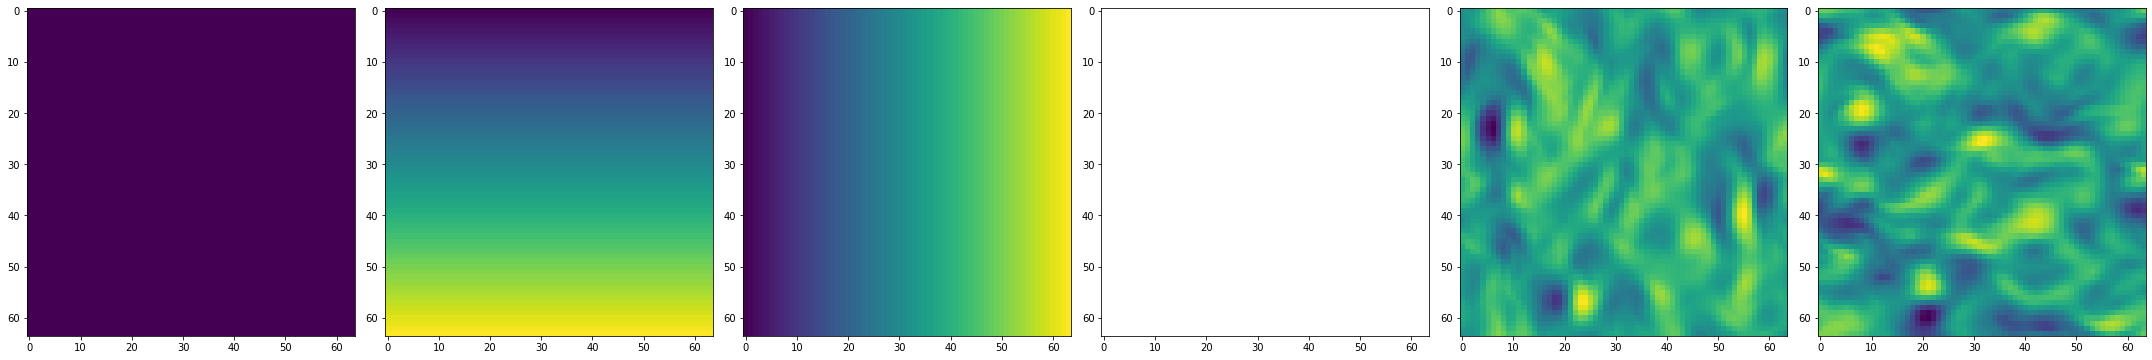

(2, 64, 64, 3)
(2, 64, 64, 2)


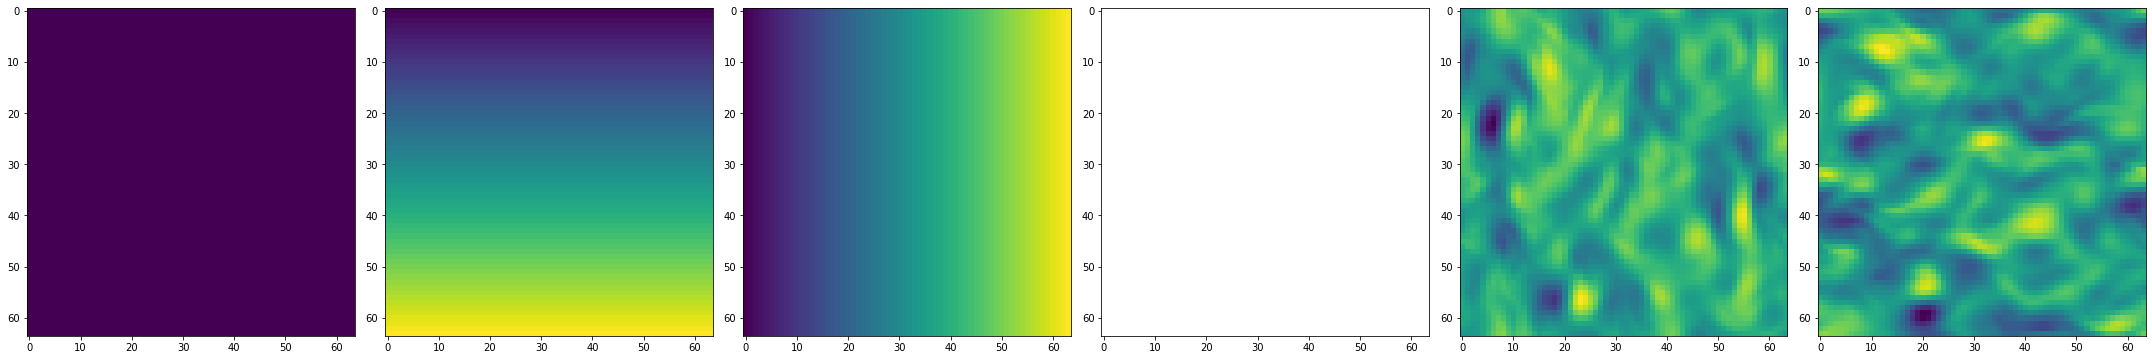

In [274]:
## test
dm.prepare_data()

print('Train')
for batch in dm.train_dataloader():
    x, y = batch  

    xshow = x.cpu().detach().numpy().squeeze().reshape(2,64,64,3)
    print(xshow.shape)
    yshow = y.cpu().detach().numpy().squeeze().reshape(2,64,64,2)
    print(yshow.shape)
    
    plt.figure(figsize=(30,10))
    plt.subplot(161)
    plt.imshow(xshow[0,:,:,0])
    plt.subplot(162)
    plt.imshow(xshow[0,:,:,1])
    plt.subplot(163)
    plt.imshow(xshow[0,:,:,2])
    plt.subplot(164)
    plt.imshow(xshow[0,:,:,2]*np.NaN)
    plt.subplot(165)
    plt.imshow(yshow[0,:,:,0])
    plt.subplot(166)
    plt.imshow(yshow[0,:,:,1])
    plt.tight_layout()
    plt.show()
    

# Model

## RFF on batch

In [275]:
class Fourier(nn.Module):
    
    def __init__(self, ndim, nfeat, scale):
        super(Fourier, self).__init__()
        self.b = nn.Parameter(torch.randn(ndim, nfeat)*scale, requires_grad=False)
        self.pi = 3.14159265359

    def forward(self, x):
        x = torch.einsum('bc,cf->bf', 2*self.pi*x, self.b.to(x.device))
        return torch.cat([torch.sin(x), torch.cos(x)], -1)

    
def LinearReLU(n_in, n_out):
    # do not work with ModuleList here either.
    block = nn.Sequential(
      nn.Linear(n_in, n_out),
      nn.ReLU()
    )
    return block

    
class MLP(nn.Module):
    
    def __init__(self, dim_layers):
        super(MLP, self).__init__()
        layers = []
        num_layers = len(dim_layers)
        
        blocks = []
        for l in range(num_layers-2):
            blocks.append(LinearReLU(dim_layers[l], dim_layers[l+1]))
            
        blocks.append(nn.Linear(dim_layers[-2], dim_layers[-1]))
        blocks.append(nn.Tanh())
        self.network = nn.Sequential(*blocks)
    
    def forward(self, x):
        return self.network(x)

    
class RFFNet_pl(pl.LightningModule):
    
    def __init__(self, name, ndim, dim_mpl_layers, f_nfeatures, f_scale, random_matrix=None, lam_pde=1e-4):
        super(RFFNet_pl, self).__init__()
        self.name = name
        self.automatic_optimization = True
        
        # regression/pinn network       
        self.rff = Fourier(ndim, f_nfeatures, f_scale) # directly the random matrix 'cause of checkpoint and load
        self.mlp = MLP(dim_mpl_layers)
        
        # PINN losses
        self.lam_pde = lam_pde
        
        # other params
        # self.mode = mode # pre_train with adam, fine_tune with bsgf
        
        # for loading from checkpoints
        self.save_hyperparameters('name', 'ndim', 'dim_mpl_layers', 'f_nfeatures', 'f_scale', 'lam_pde')
    
    def forward(self, x): # x := BxC(Batch, InputChannels)
        ## implement periodicity
        x = torch.remainder(x,1)
        ## Fourier features
        x = self.rff(x) # Batch x Fourier Features
        ## MLP
        x = self.mlp(x)
        return x

    def training_step(self, batch, batch_idx):
        # training_step defined the train loop.
        # It is independent of forward
        x, x_true = batch
        x.requires_grad_(True) # for computing the grad in the loss_pde
        x_pred = self.forward(x)
        # reconstruction loss
        loss_rec = F.mse_loss(x_pred, x_true)
        # pde loss: div(u) = 0
        if self.lam_pde > 0:
            u, v = torch.split(x_pred,1,-1)
            du_xy = torch.autograd.grad(u, x, torch.ones_like(u), create_graph=True)[0]       
            dv_xy = torch.autograd.grad(v, x, torch.ones_like(v), create_graph=True)[0]
            # last two columns are x and y
            div_u_xy = du_xy[...,0] + dv_xy[...,1]
            loss_pde = torch.norm(div_u_xy)
            loss = loss_rec + self.lam_pde*loss_pde
        else:
            loss = loss_rec
        # Logging to TensorBoard by default
        self.log('train_loss', loss)
        self.log('train_loss_data', loss_rec)
        return loss

    
    def validation_step(self, batch, batch_idx):
        # enable gradient
        torch.set_grad_enabled(True)
        x, x_true = batch
        x.requires_grad_(True) # for computing the grad in the loss_pde
        x_pred = self.forward(x)
        # reconstruction loss
        loss_rec = F.mse_loss(x_pred, x_true)
        # pde loss: div(u) = 0
        if self.lam_pde > 0:
            u, v = torch.split(x_pred,1,-1)
            du_xy = torch.autograd.grad(u, x, torch.ones_like(u), create_graph=True)[0]       
            dv_xy = torch.autograd.grad(v, x, torch.ones_like(v), create_graph=True)[0]
            # last two columns are x and y
            div_u_xy = du_xy[...,1] + dv_xy[...,2]
            loss_pde = torch.norm(div_u_xy)
            loss = loss_rec + self.lam_pde*loss_pde
        else:
            loss = loss_rec
        self.log('valid_loss', loss, on_step=True)

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-4)
#         scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer)
        return {"optimizer": optimizer}
#                 "lr_scheduler": scheduler, 
#                 "monitor": "valid_loss"}

In [276]:
# LIST OF MODELS
ndim = 3
n_features = 512
dim_layers = 1024
dim_mlp_layers = [2*n_features] + 3*[dim_layers] + [2]
scale = 10

models_hparams = {
    'RFFNet' : {
        'name' : 'RFFNet',
        'lam_pde' : 0,
    },
    'PhyRFFNet' : {
        'name' : 'PhyRFFNet',
        'lam_pde' : 1e-4,
    }
}

In [277]:
curr_model_name = 'RFFNet'
model = RFFNet_pl(curr_model_name, 
                  ndim,
                  dim_mlp_layers, 
                  n_features, 
                  scale, 
                  lam_pde=models_hparams[curr_model_name]['lam_pde'])
print(model)

RFFNet_pl(
  (rff): Fourier()
  (mlp): MLP(
    (network): Sequential(
      (0): Sequential(
        (0): Linear(in_features=1024, out_features=1024, bias=True)
        (1): ReLU()
      )
      (1): Sequential(
        (0): Linear(in_features=1024, out_features=1024, bias=True)
        (1): ReLU()
      )
      (2): Sequential(
        (0): Linear(in_features=1024, out_features=1024, bias=True)
        (1): ReLU()
      )
      (3): Linear(in_features=1024, out_features=2, bias=True)
      (4): Tanh()
    )
  )
)


In [278]:
checkpoint_dir = '../torch_checkpoints/'

In [279]:
early_stop_callback = EarlyStopping(monitor='valid_loss')
refine_sol_callback = RefineSolution(thr=1e-7)
checkpoint_callback = ModelCheckpoint(
    monitor="valid_loss",
    dirpath=checkpoint_dir,
    filename="%s-%s-{epoch:02d}-{valid_loss:.5f}" % (dm.name, model.name),
    save_top_k=2,
    mode="min",
)

trainer = pl.Trainer(gpus=1, 
                     check_val_every_n_epoch=10, 
                     max_epochs=int(10e3), 
                     callbacks=[early_stop_callback, checkpoint_callback])
trainer.fit(model, dm)

# save models
best_model_path = checkpoint_callback.best_model_path
print(checkpoint_callback.best_model_path)
torch.save(model.state_dict(), best_model_path.replace('ckpt','torch'))

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name | Type    | Params
---------------------------------
0 | rff  | Fourier | 1.5 K 
1 | mlp  | MLP     | 3.2 M 
---------------------------------
3.2 M     Trainable params
1.5 K     Non-trainable params
3.2 M     Total params
12.610    Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

/home/dicarlo_d/Documents/Code/TurboSuperResultion/torch_checkpoints/Turbo2Dtime-RFFNet-epoch=179-valid_loss=0.00000.ckpt


In [280]:
fname_rff = 'Turbo2Dtime-RFFNet-epoch=179-valid_loss=0.00000.ckpt'
fname_phy = 'Turbo2Dtime-PhyRFFNet-epoch=09-valid_loss=0.04255.ckpt'

best_model_rff = RFFNet_pl.load_from_checkpoint(checkpoint_dir + fname_rff)
best_model_phy = RFFNet_pl.load_from_checkpoint(checkpoint_dir + fname_phy)

In [281]:
print(best_model_phy.device)
print(best_model_rff.device)

cpu
cpu


In [290]:
# TEST
scale_img = 1/4
scale_time = 1/4
coords_x_ds4 = np.linspace(0, 1, int(original_img_size * scale_img))
coords_y_ds4 = np.linspace(0, 1, int(original_img_size * scale_img))
coords_t_ds5  = delta_t * np.array([0, 0.02, 0.04, 0.06])

n_time = len(coords_t_ds5)
n_space = len(coords_x_ds4)

meshgrid_test = alg.make_xyt_grid(coords_t_ds5, coords_y_ds4, coords_y_ds4)
meshgrid_test = meshgrid_test.reshape(-1,3)

x = torch.from_numpy(meshgrid_test).float().to(device)
x_shape = x.shape

In [291]:
best_model_phy.to(device)
best_model_phy.eval()

best_model_rff.to(device)
best_model_rff.eval()

ypred_rff = best_model_rff(x).cpu().detach().numpy().squeeze()
print(ypred_rff.shape)

ypred_phy = best_model_phy(x).cpu().detach().numpy().squeeze()
print(ypred_rff.shape)

(16384, 2)
(16384, 2)


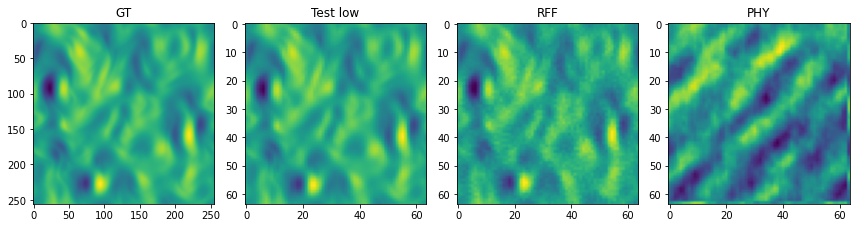

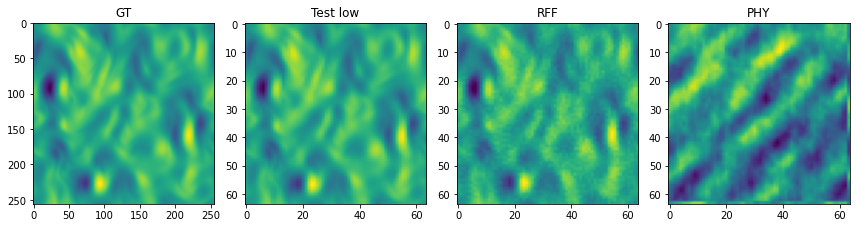

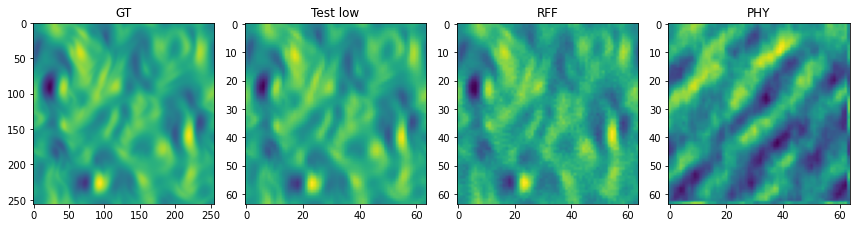

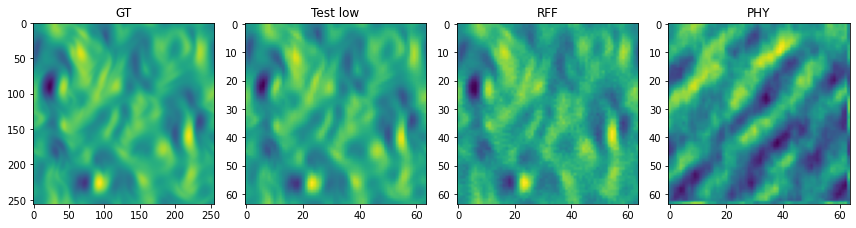

In [293]:
for t in range(n_time):
    
    plt.figure(figsize=(12,6))
    plt.subplot(141)
    plt.imshow(U[t,:,:,0])
    plt.title('GT')
    plt.subplot(142)
    plt.imshow(ylow.reshape(n_time, n_space, n_space,2)[t,:,:,0])
    plt.title('Test low')
    plt.subplot(143)
    plt.imshow(ypred_rff.reshape(n_time, n_space, n_space,2)[t,:,:,0])
    plt.title('RFF')
    plt.subplot(144)
    plt.imshow(ypred_phy.reshape(n_time, n_space, n_space,2)[t,:,:,0])
    plt.title('PHY')
    plt.tight_layout()
    plt.show()


In [ ]:
plt.figure(figsize=(12,6))
plt.subplot(131)
plt.imshow(ytest[:,:,0])
plt.title('GT')
plt.subplot(132)
plt.imshow(ypred_rff.reshape(ngrid,ngrid,2)[:,:,0])
plt.title('RFF')
plt.subplot(133)
plt.imshow(ypred_phy.reshape(ngrid,ngrid,2)[:,:,0])
plt.title('PHY')
plt.tight_layout()
plt.show()

plt.figure(figsize=(12,6))
plt.subplot(131)
plt.title('GT')
plt.imshow(ytest[:,:,1])
plt.subplot(132)
plt.title('RFF')
plt.imshow(ypred_rff.reshape(ngrid,ngrid,2)[:,:,1])
plt.subplot(133)
plt.title('PHY')
plt.imshow(ypred_phy.reshape(ngrid,ngrid,2)[:,:,1])
plt.tight_layout()
plt.show()

In [ ]:
fig, axs = plt.subplots(1,1,figsize=(5,5))
axs.loglog(np.arange(len(phy.powerspec(ytrain[:,:,0]))), phy.powerspec(ytrain[:,:,0]), label='U train 64')
axs.loglog(np.arange(len(phy.powerspec(ytest[:,:,0]))), phy.powerspec(ytest[:,:,0]), label='U test 256')
axs.loglog(np.arange(len(phy.powerspec(yup2[:,:,0]))), phy.powerspec(yup2[:,:,0]), label='U upsampled 256')
axs.loglog(np.arange(len(phy.powerspec(ypred_rff.reshape(ngrid,ngrid,2)[:,:,0]))), 
                         phy.powerspec(ypred_rff.reshape(ngrid,ngrid,2)[:,:,0]), label='RFF')
axs.loglog(np.arange(len(phy.powerspec(ypred_phy.reshape(ngrid,ngrid,2)[:,:,0]))), 
                         phy.powerspec(ypred_phy.reshape(ngrid,ngrid,2)[:,:,0]), label='PHY')
axs.set_ylim(10**(-15), 10)
axs.set_xlim(1, 512)
axs.legend()
plt.tight_layout()
plt.show()